# Mount and Importing Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from google.colab import files
uploaded = files.upload()

Saving tumor_detection_model.h5 to tumor_detection_model.h5


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix

data_dir = '/content/drive/MyDrive/DataSets/Data'

# ImageDataGenerators for loading and augmenting data

In [ ]:
import os
import shutil

!mkdir -p /content/merged_data

source_dirs = {
    'glioma': '/content/drive/MyDrive/DataSets/Data/Tumor/glioma_tumor',
    'meningioma': '/content/drive/MyDrive/DataSets/Data/Tumor/meningioma_tumor',
    'pituitory': '/content/drive/MyDrive/DataSets/Data/Tumor/pituitary_tumor',
    'normal': '/content/drive/MyDrive/DataSets/Data/Normal'
}

for label, path in source_dirs.items():
    target_dir = f'/content/merged_data/{label}'
    os.makedirs(target_dir, exist_ok=True)

    for i, img in enumerate(os.listdir(path)):
        if img.lower().endswith(('.jpg', '.png', '.jpeg')):
            src = os.path.join(path, img)
            dst = os.path.join(target_dir, f'{label}_{i}.jpg')
            shutil.copy(src, dst)

In [ ]:
img_size = 150
batch_size = 32

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    '/content/merged_data',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)

val_generator = datagen.flow_from_directory(
    '/content/merged_data',
    target_size=(img_size, img_size),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

print(train_generator.class_indices)

Found 17339 images belonging to 4 classes.
Found 4333 images belonging to 4 classes.
{'glioma': 0, 'meningioma': 1, 'normal': 2, 'pituitory': 3}


# CNN Model

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(4, activation='softmax')  # 4 output classes
])

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,828,868 (18.42 MB)

 Trainable params: 4,828,868 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

Epoch 1/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 1021s 2s/step - accuracy: 0.5270 - loss: 1.0991 - val_accuracy: 0.6393 - val_loss: 0.8947
Epoch 2/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 1005s 2s/step - accuracy: 0.6929 - loss: 0.7258 - val_accuracy: 0.7175 - val_loss: 0.7718
Epoch 3/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 986s 2s/step - accuracy: 0.7881 - loss: 0.5439 - val_accuracy: 0.7561 - val_loss: 0.7469
Epoch 4/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 1038s 2s/step - accuracy: 0.8367 - loss: 0.4268 - val_accuracy: 0.7881 - val_loss: 0.6343
Epoch 5/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 988s 2s/step - accuracy: 0.8666 - loss: 0.3492 - val_accuracy: 0.8036 - val_loss: 0.6261
Epoch 6/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 1036s 2s/step - accuracy: 0.8890 - loss: 0.2881 - val_accuracy: 0.8108 - val_loss: 0.6352
Epoch 7/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 1038s 2s/step - accuracy: 0.9054 - loss: 0.2452 - val_accuracy: 0.8260 - val_loss: 0.6016
Epoch 8/10
542/542 ━━━━━━━━━━━━━━━━━━━━ 1036s 2s/step - accuracy: 0.9157 - loss: 0.2226 - va

# Evaluating Model

In [ ]:
val_loss, val_acc = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_acc * 100:.2f}%")

136/136 ━━━━━━━━━━━━━━━━━━━━ 85s 628ms/step - accuracy: 0.8397 - loss: 0.6808
Validation Accuracy: 83.84%


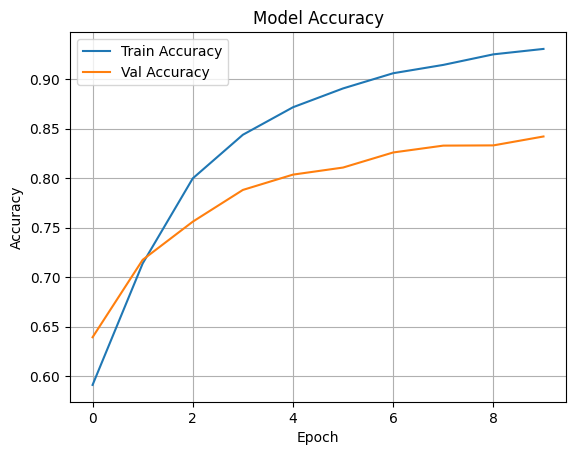

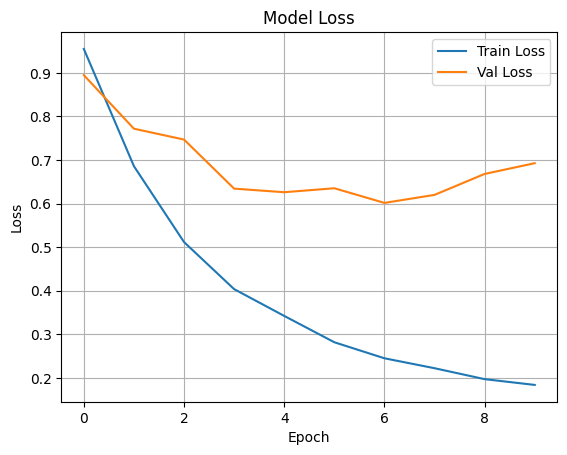

In [ ]:
import matplotlib.pyplot as plt

# Accuracy Plot
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss Plot
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Model Saving

In [ ]:
model.save('/content/drive/MyDrive/tumor_detection_model.h5')

In [ ]:
import tensorflow as tf

model = tf.keras.models.load_model('tumor_detection_model.h5')

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open('tumor_model.tflite', 'wb') as f:
    f.write(tflite_model)

Saved artifact at '/tmp/tmp34y9s76y'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name='input_layer_2')
Output Type:
  TensorSpec(shape=(None, 4), dtype=tf.float32, name=None)
Captures:
  138858179992976: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858179997584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858179998736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858179996816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858179997008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858360125584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858360117904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858360116560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858179997200: TensorSpec(shape=(), dtype=tf.resource, name=None)
  138858179994896: TensorSpec(shape=(), dtype=tf.resource, name=None)


In [ ]:
from google.colab import files
files.download('tumor_model.tflite')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Prediction

In [ ]:
img_path = '/content/drive/MyDrive/DataSets/Data/Tumor/glioma_tumor/G_1.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
prediction = model.predict(img_array)
class_names = list(train_generator.class_indices.keys())
predicted_class = class_names[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 284ms/step
Predicted class: glioma


In [ ]:
img_path = '/content/drive/MyDrive/DataSets/Data/Normal/N_1.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
prediction = model.predict(img_array)
class_names = list(train_generator.class_indices.keys())
predicted_class = class_names[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
Predicted class: normal


In [ ]:
img_path = '/content/drive/MyDrive/DataSets/Data/Tumor/meningioma_tumor/M_100.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
prediction = model.predict(img_array)
class_names = list(train_generator.class_indices.keys())
predicted_class = class_names[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
Predicted class: meningioma


In [ ]:
img_path = '/content/drive/MyDrive/DataSets/Data/Tumor/pituitary_tumor/P_100_DA_.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
prediction = model.predict(img_array)
class_names = list(train_generator.class_indices.keys())
predicted_class = class_names[np.argmax(prediction)]

print(f"Predicted class: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
Predicted class: pituitory


In [ ]:
img_path = '/content/drive/MyDrive/DataSets/MRI images/Testing/notumor/Te-noTr_0000.jpg'

from tensorflow.keras.preprocessing import image
import numpy as np

# Load and preprocess the image
img = image.load_img(img_path, target_size=(150, 150))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0) / 255.0

# Predict
prediction = model.predict(img_array)
predicted_index = np.argmax(prediction)
class_names = list(train_generator.class_indices.keys())
predicted_class = class_names[np.argmax(prediction)]
confidence = prediction[0][predicted_index] * 100


print(f"Predicted class: {predicted_class}")
print(f"Confidence: {confidence:.2f}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Predicted class: normal
Confidence: 88.07%
